In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain-openai langchain-groq python-dotenv langchain beautifulsoup4

In [2]:
import getpass
import os
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv()) # read local .env file
if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

## Define Models

In [3]:
# from langchain_openai import ChatOpenAI # type: ignore
# model = ChatOpenAI(model="gpt-4o-mini")

from langchain_groq import ChatGroq # type: ignore

model = ChatGroq(
    model="llama3-70b-8192",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)


model_with_tools = ChatGroq(
    model="llama3-70b-8192",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

# Agent Workflow

In [4]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage 
from langgraph.graph.message import add_messages 


class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    review_type: str
    db_type: str

## Classification Node

In [5]:
classification_prompt_template = (
                            """
                            Classify the user query into one of the following categories:  
                            - Descriptive: if the user is asking for general information or details about a particular subject.  
                            - Comparison: if the user is comparing two or more items to understand which one is better or to see differences.  
                            - Recommendation: if the user is seeking suggestions or advice for a particular choice.  

                            Based on the query, also choose the most appropriate database from the following options:  
                            - Amazon: for product-related queries or recommendations.  
                            - IMDb: for movie or TV show-related queries, comparisons, or recommendations.  
                            - Yelp: for queries related to restaurants, businesses, or local services.  

                            Examples:  
                            - Descriptive: "What is the best movie of all time?" -> Database: IMDb  
                            - Comparison: "Which movie is better, Inception or Interstellar?" -> Database: IMDb  
                            - Recommendation: "Suggest some good restaurants nearby." -> Database: Yelp  

                            Your task:  
                            Given the user query below, classify it into one of the categories (descriptive, comparison, recommendation) and choose the appropriate database (amazon, imdb, yelp).  

                            {format_instructions}  

                            Query: {query}

                            """
                        )

In [6]:
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import AIMessage
import json


class ClassificationNodeOutput(BaseModel):
    query: str = Field(description="The query from the user")
    query_type: str = Field(description="The type of the query: descriptive, comparison, or recommendation")
    db: str = Field(description="The type of the database to search from: amazon, imdb, or yelp")


class ClassificationNode():
    @staticmethod
    def classify_query(state: AgentState):
        parser = PydanticOutputParser(pydantic_object=ClassificationNodeOutput)
        classification_prompt = PromptTemplate(
                        template=classification_prompt_template, 
                        input_variables=["query"],
                        partial_variables={"format_instructions": parser.get_format_instructions()},
                    )
        classification_model = classification_prompt | model
        query = state["messages"][0].content
        output = classification_model.invoke({"query": query})
        response: ClassificationNodeOutput = parser.invoke(output)
        AIMessageresponse = AIMessage(content=json.dumps(response.model_dump()), name="classification_node" ,additional_kwargs = {"query": query, "json_output": response.model_dump()})
        return {"messages": [AIMessageresponse], "query_type": response.query_type, "db_type": response.db}


## CategoryNodeCreator 

In [7]:
comparison_prompt_template = (
           """You are an expert comparison analyst specialized in structured analysis. Your task is to analyze this query: {query}

Your role is to:
1. Identify the items being compared
2. Determine their category/field
3. Create relevant comparison criteria
4. Ensure the criteria list contains keywords and phrases that will optimize relevance in a semantic search, particularly for use in a vector database.
5. Structure the output as JSON

Example criteria by category:

MOVIES:
- Genre alignment
- Audience ratings and review sentiment
- Plot complexity and originality
- Character development
- Technical aspects (effects, cinematography)
- Cultural impact and legacy

BOOKS:
- Genre and thematic alignment
- Writing style and readability
- Character development and depth
- Plot complexity and originality
- Critical reviews and reader sentiment
- Author reputation and influence
- Cultural impact and legacy

RESTAURANTS/SERVICES:
- Quality of service/food
- Price range comparison
- Atmosphere and ambiance
- Location and accessibility
- Customer satisfaction metrics
- Unique selling points

the output should be structured as follows:
    "query": "query",
    "items": ["item1", "item2"],
    "category": "category",
    "criteria": ["criterion1", "criterion2"]


REMEMBER: Your analysis should be structured, detailed, and relevant to the query. 
DONT ADD ANYTHING ELSE TO THE OUTPUT.
You must always return valid JSON fenced by a markdown code block. Do not return any additional text.
"""
)


descriptive_prompt_template = (
    """
    You are an expert in descriptive analysis, specializing in creating comprehensive lists of key elements, Themes, or characteristics that are central to answering detailed query.
    Your goal is to produce a detailed list of concepts, keywords, and specific features related to the main topic of the query:

    {query}

    To structure your response:
    1. **Analyze the query**: Identify the main topic and any specific subcategories or descriptors implied in the query.
    2. **Generate a List of Keywords**: Think about genres, notable characteristics, influential figures, popular examples, and historical context relevant to the query. Include broad themes and specific details.
    3. **Support Semantic Search**: Ensure that each keyword or phrase will enhance the relevance of results in a vector database search.

    Example:
    - **query**: 'What is the best science fiction movie of all time?'
    - **Primary Focus**: 'movies'
    - **Keywords**: ['science fiction genre', 'top-rated movies', 'popular sci-fi themes', 'influential directors in sci-fi', 'groundbreaking special effects', 'futuristic setting', 'classic sci-fi films']

    REMEMBER: Your analysis should be structured, detailed, and relevant to the query. 
    DONT ADD ANYTHING ELSE TO THE OUTPUT.
    DONT FORGET to add the query, primary focus, and keywords to the JSON response.
    You must always return valid JSON fenced by a markdown code block. Do not return any additional text.
    """
)


recommendation_prompt_template = (
            """You are an expert recommendation analyst. Your task is to analyze this query: {query}

                Your role is to:
                1. Determine the category/field for the query
                2. Generate relevant criteria to make top recommendations
                3. Structure the output as JSON

                **Example criteria by category:**

                MOVIES:
                - Genre alignment with viewer interests
                - Audience ratings and review sentiment
                - Plot originality and complexity
                - Character and actor performance
                - Publicity events for movie promotions
                - Actors familiarity and fan following
                - Technical quality (cinematography, effects, vfx, screenplay)
                - Legacy and cultural relevance
                - Relatability to the viewer
                - Unique factor to attract the audience

                RESTAURANTS:
                - Food quality (ingredients, freshness)
                - Price range and value for money
                - Ambiance (interior design, atmosphere)
                - Chef expertise and background
                - Preparation techniques (traditional, fusion)
                - Menu authenticity
                - Accessibility (location, parking)
                - Customer feedback and service
                - Specialty offerings (unique dishes, chef’s expertise)
                - Cultural dining practices
                - Take out options
                - Dietary accomodations (Vegetarian, vegan)

                BOOKS:
                - Genre suitability
                - Reader engagement (plot, character depth)
                - Book popularity 
                - Awards and features for the author and book
                - Writing style and originality
                - Critical reviews and ratings
                - Influence and cultural impact
                - Author reputation
                - Level of reader
                - Language of the book written in 
                - References and sources


                the output should be structured as follows:
                    "query": "query",
                    "category": "category",
                    "criteria": ["criterion1", "criterion2"]


                REMEMBER: Your analysis should be structured, detailed, and relevant to the query. 
                DONT ADD ANYTHING ELSE TO THE OUTPUT.
                You must always return valid JSON fenced by a markdown code block. Do not return any additional text.
                """
            )

In [8]:
class DescriptivePromptInput(BaseModel):
    query: str = Field(description="The query from the user.")
    primary_focus: str = Field(description="The primary category or topic type of the query (e.g., 'movies', 'technology', 'books').")
    keywords: Sequence[str] = Field(description="A list of keywords and phrases extracted from the query that will assist in semantic search.")


class ComparisonPromptInput(BaseModel):
    query: str = Field(description="the query from the user")
    items: Sequence[str] = Field(description="the items being compared")
    category: str = Field(description="the category/field of the items being compared")
    criteria: Sequence[str] = Field(description="the criteria for comparison, optimized for semantic search relevance")
   

class RecommendationPromptInput(BaseModel):
    query: str = Field(description="the query from the user")
    category: str = Field(description="the category/field of the items being recommendation")
    criteria: Sequence[str] = Field(description="the criteria for recommendation, optimized for semantic search relevance")

In [9]:
from abc import ABC, abstractmethod


class Category(ABC):
    @abstractmethod
    def process_query(state: AgentState):
        """Process the query based on the category type."""
        pass

class RecommendationCategory(Category):
    @staticmethod
    def process_query(state: AgentState):
        parser = PydanticOutputParser(pydantic_object=RecommendationPromptInput)

        prompt = PromptTemplate(
                    template=recommendation_prompt_template,
                    input_variables=["query"],
                    partial_variables={"format_instructions": parser.get_format_instructions()},
                )

        recommendation_model = prompt | model
        query = state["messages"][0].content
        output = recommendation_model.invoke({"query": query})
        response: RecommendationPromptInput = parser.invoke(output)
        AIMessageresponse = AIMessage(content=json.dumps(response.model_dump()), name="recommendation_node" ,additional_kwargs = {"query": query, "json_output": response.model_dump()})
        return {"messages": [AIMessageresponse]}

class DescriptiveCategory(Category):
    @staticmethod
    def process_query(state: AgentState):
        parser = PydanticOutputParser(pydantic_object=DescriptivePromptInput)

        prompt = PromptTemplate(
                    template=descriptive_prompt_template,
                    input_variables=["query"],
                    partial_variables={"format_instructions": parser.get_format_instructions()},
                )

        description_model = prompt | model
        query = state["messages"][0].content
        output = description_model.invoke({"query": query})
        response: DescriptivePromptInput = parser.invoke(output)
        AIMessageresponse = AIMessage(content=json.dumps(response.model_dump()), name="description_node" ,additional_kwargs = {"query": query, "json_output": response.model_dump()})
        return {"messages": [AIMessageresponse]}


class ComparisonCategory(Category):
    @staticmethod
    def process_query(state: AgentState):
        parser = PydanticOutputParser(pydantic_object=ComparisonPromptInput)

        prompt = PromptTemplate(
                    template=comparison_prompt_template,
                    input_variables=["query"],
                    partial_variables={"format_instructions": parser.get_format_instructions()},
                )

        comparison_model = prompt | model
        
        query = state["messages"][0].content
        output = comparison_model.invoke({"query": query})
        response: ComparisonPromptInput = parser.invoke(output)
        AIMessageresponse = AIMessage(content=json.dumps(response.model_dump()), name="comparison_node" ,additional_kwargs = {"query": query, "json_output": response.model_dump()})
        return {"messages": [AIMessageresponse]}


class CategoryFactoryCreator:
    @staticmethod
    def create_category_node(category_type: str) -> Category:
        """Factory method to create a category instance based on the type."""
        if category_type.lower() == "recommendation":
            return RecommendationCategory()
        elif category_type.lower() == "description":
            return DescriptiveCategory()
        elif category_type.lower() == "comparison":
            return ComparisonCategory()
        else:
            raise ValueError(f"Unknown category type: {category_type}")



## Database Selector

In [10]:
def db_selector_node(state: AgentState):
    print("================================ db_selector_node ================================")
    print(state)
    return

def which_type_review(state: AgentState):
    type = state["query_type"]
    return type if type in ["comparison", "recommendation", "descriptive"] else None

## Workflow

In [11]:
from langgraph.graph import StateGraph, END

def run_workflow():
    workflow = StateGraph(AgentState)

    workflow.add_node("classification node", ClassificationNode.classify_query)

    workflow.add_node("comparison node", ComparisonCategory.process_query)
    workflow.add_node("recommendation node", RecommendationCategory.process_query)
    workflow.add_node("descriptive node", DescriptiveCategory.process_query)

    workflow.add_node("db selector", db_selector_node)

    workflow.set_entry_point("classification node")
    
    workflow.add_conditional_edges("classification node", which_type_review,
        {
            "comparison": "comparison node",
            "recommendation": "recommendation node",
            "descriptive": "descriptive node",                                           
        })

    workflow.add_edge("comparison node", "db selector")
    workflow.add_edge("recommendation node", "db selector")
    workflow.add_edge("descriptive node", "db selector")

    workflow.add_edge("db selector", END)

    return workflow


agent_graph = run_workflow().compile(debug=True)

In [12]:
import pprint

def stream_graph(stream):
    for s in stream:
        
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            if message.name:
                if message.type == "ai":
                    print(f'================================== \033[1m{message.name} AI Message\033[0m ==================================')
                print(f"the query is: {message.additional_kwargs['query']} ")
                print(f"the string response is: {message.content}")
                print("the json response is:")
                pprint.pprint(message.additional_kwargs["json_output"])
            else:
                message.pretty_print()

In [13]:
descriptive_inputs = {"messages": [("user", "what is your opinion about the movie Avengers End Game?")]}
stream_graph(agent_graph.stream(descriptive_inputs, stream_mode="values"))

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user',
               'what is your opinion about the movie Avengers End Game?')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user', 'what is your opinion about the movie Avengers End Game?')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='what is your opinion about the movie Avengers End Game?', additional_kwargs={}, response_metadata={}, id='ccb46eb4-1ffb-4da2-b18c-2a4bcec0f99b')]}
[1:tasks] Starting 1 task for step 1:
- classification node -> {'messages': [HumanMessage(content='what is your opinion about the movie Avengers End Game?', additional_kwargs={}, response_metadata={}, id='ccb46eb4-1ffb-4da2-b18c-2a4bcec0f99b')]}
================================ Human Message =================================

what is your opinion about the movie Avengers End Game?
[1:writes] Finished step 1 with writes 

In [14]:
comparison_input = {"messages": [("user", "what should i watch spiderman or deadpool?")]}
stream_graph(agent_graph.stream(comparison_input, stream_mode="values"))

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user', 'what should i watch spiderman or deadpool?')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user', 'what should i watch spiderman or deadpool?')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='what should i watch spiderman or deadpool?', additional_kwargs={}, response_metadata={}, id='c239d355-3534-45df-80cd-a566a02552e3')]}
[1:tasks] Starting 1 task for step 1:
- classification node -> {'messages': [HumanMessage(content='what should i watch spiderman or deadpool?', additional_kwargs={}, response_metadata={}, id='c239d355-3534-45df-80cd-a566a02552e3')]}
================================ Human Message =================================

what should i watch spiderman or deadpool?
[1:writes] Finished step 1 with writes to 2 channels:
- messages -> [AIMessage(content='{"query": "what should i watch 

In [15]:
recommendation_input = {"messages": [("user", "Recommend the best restaurant in california for mediterranean food")]}
stream_graph(agent_graph.stream(recommendation_input, stream_mode="values"))

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user',
               'Recommend the best restaurant in california for mediterranean '
               'food')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user', 'Recommend the best restaurant in california for mediterranean food')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='Recommend the best restaurant in california for mediterranean food', additional_kwargs={}, response_metadata={}, id='d000da6b-344d-48aa-895f-6fda9cafbc96')]}
[1:tasks] Starting 1 task for step 1:
- classification node -> {'messages': [HumanMessage(content='Recommend the best restaurant in california for mediterranean food', additional_kwargs={}, response_metadata={}, id='d000da6b-344d-48aa-895f-6fda9cafbc96')]}
================================ Human Message =================================

Recommend the best restaurant in 

## Workflow Graph

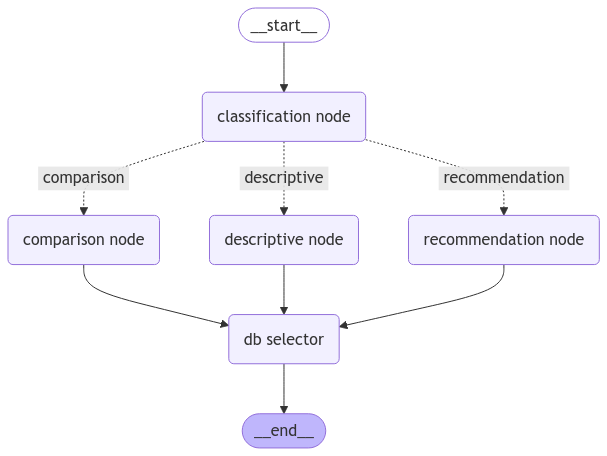

In [16]:
from IPython.display import Image, display # type: ignore

try:
    display(Image(agent_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass